In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


# === 1. Create homography matrix ===
def create_homography(pts_dst, pts_src):
    """
    Computes the homography matrix from pts_src to pts_dst.
    """
    H, _ = cv2.findHomography(pts_src, pts_dst)
    return H

# === 2. Convert grid index (i, j) to image coordinates (u, v) ===
def grid_to_image(i, j, H_grid_to_world, H_world_to_image):
    """
    Converts a grid cell (i, j) to its corresponding image pixel (u, v),
    using two homographies: grid→world, world→image.
    """
    # Convert grid index to homogeneous point
    point_grid = np.array([j, i, 1.0], dtype=np.uint8)

    # Map to world coordinates
    point_world = H_grid_to_world @ point_grid
    point_world /= point_world[2]
    lon, lat = point_world[0], point_world[1]

    # Map to image coordinates
    point_world_hom = np.array([lon, lat, 1.0], dtype=np.uint8)
    point_image = H_world_to_image @ point_world_hom
    point_image /= point_image[2]
    u, v = point_image[0], point_image[1]

    return u, v

# === 3. Map entire grid to image using homographies and remap ===
# def warp_image_to_grid(grid, image, H_grid_to_world, H_world_to_image, grid_height, grid_width):
#     """
#     Projects the image onto the grid and returns a new updated grid (copy),
#     where only valid points (inside image bounds) are updated.
#     """
#     grid_height, grid_width = grid.shape
#     new_grid = grid.copy()

#     # 1. Create grid indices
#     # jj, ii = np.meshgrid(np.arange(grid_width), np.arange(grid_height))
#     jj, ii = np.meshgrid(
#         np.arange(grid_width, dtype=np.uint16),
#         np.arange(grid_height, dtype=np.uint16)
#     )
#     grid_points = np.stack([jj.ravel(), ii.ravel(), np.ones_like(jj).ravel()], axis=-1).T

#     # 2. Grid → World
#     world_coords = H_grid_to_world @ grid_points
#     world_coords /= world_coords[2, :]

#     # 3. World → Image
#     image_coords = H_world_to_image @ world_coords
#     image_coords /= image_coords[2, :]

#     u = image_coords[0, :].reshape((grid_height, grid_width)).astype(np.float32)
#     v = image_coords[1, :].reshape((grid_height, grid_width)).astype(np.float32)

#     # 4. Sample from image
#     sampled_values = cv2.remap(image.astype(np.uint8), u, v,
#                                interpolation=cv2.INTER_LINEAR,
#                                borderMode=cv2.BORDER_CONSTANT,
#                                borderValue=0)

#     # 5. Validity mask: where (u, v) inside image bounds
#     valid_mask = (u > 0) & (u < image.shape[1]-1) & (v > 0) & (v < image.shape[0]-1)

#     # 6. Update only valid pixels
#     new_grid[valid_mask] = sampled_values[valid_mask]

#     return new_grid

def warp_image_to_grid(grid, image, H_grid_to_world, H_world_to_image, grid_height, grid_width):
    """
    Projects the image onto the grid and returns a new updated grid (copy),
    where only valid points (inside image bounds) are updated.

    This version is optimized for memory by using float32 and np.indices.
    """
    # Copy the original grid to update only valid regions
    new_grid = grid.copy()

    # 1. Generate grid coordinates (i, j)
    ii, jj = np.indices((grid_height, grid_width), dtype=np.float32)  # shape: (2, H, W)

    # 2. Flatten and convert to homogeneous grid coordinates (j, i, 1)
    ones = np.ones_like(ii)
    grid_points = np.stack([jj, ii, ones], axis=0).reshape(3, -1)  # shape: (3, H*W)

    # 3. Grid → World
    world_coords = H_grid_to_world @ grid_points
    world_coords /= world_coords[2, :]  # normalize homogeneous

    # 4. World → Image
    image_coords = H_world_to_image @ world_coords
    image_coords /= image_coords[2, :]  # normalize homogeneous

    # 5. Reshape u, v
    u = image_coords[0, :].reshape((grid_height, grid_width)).astype(np.float32)
    v = image_coords[1, :].reshape((grid_height, grid_width)).astype(np.float32)

    # 6. Sample from image using OpenCV remap
    sampled_values = cv2.remap(image.astype(np.float32), u, v,
                               interpolation=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT,
                               borderValue=0)

    # 7. Validity mask: only update values that fall inside the image
    valid_mask = (u >= 0) & (u < image.shape[1]) & (v >= 0) & (v < image.shape[0])
    new_grid[valid_mask] = sampled_values[valid_mask]

    return new_grid


# === 4. Compute difference ===
def compute_difference_map(original, updated):
    return updated - original

# === 5. Find subgrid coordinates ===
def get_subgrid_bounds_precise(pts_world, lon_origin, lat_origin, resolution, grid_width=None, grid_height=None):
    """
    Given 4 world points (lon, lat), return the min/max grid *locations* (not indices),
    by projecting to grid coordinates and flooring/ceiling the outer bounds.

    Returns:
        j_min, j_max, i_min, i_max — grid locations (not necessarily integer indices)
    """
    lon = np.asarray(pts_world[:, 0])
    lat = np.asarray(pts_world[:, 1])

    # Map to real-valued grid locations
    j_float = (lon - lon_origin) / resolution
    i_float = (lat - lat_origin) / resolution

    padding_marg = 10
    # Apply floor/ceil to get enclosing bounds
    j_min = np.floor(np.min(j_float)) - padding_marg
    j_max = np.ceil(np.max(j_float)) + padding_marg
    i_min = np.floor(np.min(i_float)) - padding_marg
    i_max = np.ceil(np.max(i_float)) + padding_marg

    # Clip to grid size if specified
    if grid_width is not None:
        j_min = max(j_min, 0)
        j_max = min(j_max, grid_width - 1)

    if grid_height is not None:
        i_min = max(i_min, 0)
        i_max = min(i_max, grid_height - 1)

    return j_min, j_max, i_min, i_max

# === 5. Creating subgrid ===
def extract_subgrid_from_bounds(grid, j_min, j_max, i_min, i_max):
    """
    Cuts a subgrid from the full grid using float-based grid bounds.

    Parameters:
        grid: 2D array [height, width]
        j_min, j_max, i_min, i_max: float grid locations

    Returns:
        subgrid: 2D array (sliced from grid)
        i_start, i_end, j_start, j_end: integer indices used
    """
    # Convert float positions to integer indices
    j_start = int(j_min)
    j_end   = int(j_max)
    i_start = int(i_min)
    i_end   = int(i_max)

    # Cut the subgrid
    subgrid = grid[i_start:i_end, j_start:j_end]

    return subgrid, i_start, i_end, j_start, j_end


def create_subgrid_from_bounds(lon_min, lon_max, lat_min, lat_max, resolution):
    """
    Cuts a subgrid from the full grid using float-based grid bounds.

    Parameters:
        grid: 2D array [height, width]
        j_min, j_max, i_min, i_max: float grid locations

    Returns:
        subgrid: 2D array (sliced from grid)
        i_start, i_end, j_start, j_end: integer indices used
    """

    # Determine shape of the subgrid
    subgrid_width = int((lon_max - lon_min) / resolution)
    subgrid_height = int((lat_max - lat_min) / resolution)

    # Create subgrid filled with NaNs
    subgrid = np.full((subgrid_height, subgrid_width), np.nan, dtype=np.uint8)

    return subgrid
    

## Find Diff

def preprocess_images(image1, image2, applying=0):
    img1 = image1.astype(np.uint8)
    img2 = image2.astype(np.uint8)

    if applying > 0:
        img1 = img1 - img1.mean()
        img2 = img2 - img2.mean()

    return img1, img2

def compute_positive_difference(img1, img2):
    diff = img2 - img1
    diff[np.isnan(diff)] = 0
    diff[diff < 0] = 0
    return diff

def postprocess_difference_map(diff, img2, threshold=None, temp_threshold=None):
    """
    Post-processes the difference map by zeroing out pixels that do not meet the conditions.

    Parameters:
        diff: difference map (2D array)
        img2: reference image (same shape)
        threshold: minimum value in diff to keep (None = no filtering)
        temp_threshold: intensity threshold based on mean of img2 (None = no filtering)

    Returns:
        diff: diff map after zeroing out irrelevant pixels
    """
    if threshold is not None:
        diff[diff <= threshold] = 0

    if temp_threshold is not None:
        temp_mask = img2 <= (img2.mean() + temp_threshold)
        diff[temp_mask] = 0

    return diff



# def extract_and_resample_subgrid_interp(grid, resolution, res, j_min, j_max, i_min, i_max):
#     """
#     Extracts a region from a high-resolution grid and resamples it using interpolation to a new resolution.

#     Parameters:
#         grid: 2D numpy array (original high-res grid)
#         resolution: original grid resolution (e.g., 0.02 degrees)
#         res: desired new resolution (e.g., 0.07 degrees)
#         j_min, j_max, i_min, i_max: float bounds (in grid coordinates)

#     Returns:
#         subgrid_interp: 2D numpy array resampled to new resolution
#         lon_new, lat_new: 1D arrays with the coordinates of the new grid
#     """
#     # Convert bounds to original grid coordinate system (indices)
#     j_start = max(0, int(np.floor(j_min)))
#     j_end   = min(grid.shape[1], int(np.ceil(j_max)))
#     i_start = max(0, int(np.floor(i_min)))
#     i_end   = min(grid.shape[0], int(np.ceil(i_max)))

#     # Extract high-resolution subgrid
#     subgrid_highres = grid[i_start:i_end, j_start:j_end]

#     # Compute coordinate arrays (in "world units" like lon/lat)
#     lat_vals = (np.arange(i_start, i_end) * resolution).astype(np.float32)
#     lon_vals = (np.arange(j_start, j_end) * resolution).astype(np.float32)

#     # Create interpolator
#     interpolator = RegularGridInterpolator((lat_vals, lon_vals), subgrid_highres, bounds_error=False, fill_value=255)

#     # Define new coarser grid (in world coordinates)
#     lat_min_val = i_start * resolution
#     lat_max_val = (i_end) * resolution
#     lon_min_val = j_start * resolution
#     lon_max_val = (j_end) * resolution

#     lat_new = np.arange(lat_min_val, lat_max_val + res, res)
#     lon_new = np.arange(lon_min_val, lon_max_val + res, res)

#     # Create meshgrid of new points
#     lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)
#     sample_points = np.stack([lat_mesh.ravel(), lon_mesh.ravel()], axis=-1)

#     # Check which points are out of bounds
#     lat_min, lat_max = lat_vals[0], lat_vals[-1]
#     lon_min, lon_max = lon_vals[0], lon_vals[-1]
    
#     out_of_bounds_mask = (
#         (sample_points[:, 0] < lat_min) | (sample_points[:, 0] > lat_max) |
#         (sample_points[:, 1] < lon_min) | (sample_points[:, 1] > lon_max)
#     )
    
#     num_out_of_bounds = np.count_nonzero(out_of_bounds_mask)
#     if num_out_of_bounds > 0:
#         print(f"⚠️ Warning: {num_out_of_bounds} sample points are outside the interpolation bounds! Filling with 255.")



#     # Interpolate
#     subgrid_interp = interpolator(sample_points).reshape(lat_mesh.shape)

#     return subgrid_interp, lon_new, lat_new
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def extract_and_resample_subgrid_interp(grid, resolution, res, j_min, j_max, i_min, i_max):
    """
    Extracts a region from a high-resolution grid and resamples it using interpolation to a new resolution.

    Parameters:
        grid: 2D numpy array (original high-res grid)
        resolution: original grid resolution (e.g., 1 meter per cell)
        res: desired new resolution (e.g., 5 meters per cell)
        j_min, j_max, i_min, i_max: float bounds (in grid coordinates)

    Returns:
        subgrid_interp: 2D numpy array resampled to new resolution
        lon_new, lat_new: 1D arrays with the coordinates of the new grid
    """

    # Step 1: Convert float bounds to integer indices (safe)
    j_start = max(0, int(np.floor(j_min)))
    j_end   = min(grid.shape[1], int(np.ceil(j_max)))
    i_start = max(0, int(np.floor(i_min)))
    i_end   = min(grid.shape[0], int(np.ceil(i_max)))

    # Step 2: Extract subgrid
    subgrid_highres = grid[i_start:i_end, j_start:j_end]

    # Step 3: Compute lat/lon coordinate axes in world units
    lat_vals = (np.arange(i_start, i_end) * resolution).astype(np.float64)
    lon_vals = (np.arange(j_start, j_end) * resolution).astype(np.float64)

    # Step 4: Build interpolator over the high-res subgrid
    interpolator = RegularGridInterpolator(
        (lat_vals, lon_vals),
        subgrid_highres,
        bounds_error=False,
        fill_value=255
    )

    # Step 5: Carefully generate coarse-resolution grid inside valid bounds
    def safe_arange(start, stop, step):
        """Like np.arange, but ensures last value doesn't exceed stop."""
        vals = []
        v = start
        while v <= stop:
            vals.append(v)
            v += step
        return np.array(vals, dtype=np.float64)

    lat_new = safe_arange(lat_vals[0], lat_vals[-1], res)
    lon_new = safe_arange(lon_vals[0], lon_vals[-1], res)

    # Step 6: Create sampling meshgrid and interpolate
    lon_mesh, lat_mesh = np.meshgrid(lon_new, lat_new)
    sample_points = np.stack([lat_mesh.ravel(), lon_mesh.ravel()], axis=-1)

    # Step 7: Interpolate
    subgrid_interp = interpolator(sample_points).reshape(lat_mesh.shape)

    return subgrid_interp, lon_new, lat_new


def create_synthetic_image_with_clusters(image_height, image_width,
                                         background_range=(3, 7),
                                         cluster_value=200,
                                         num_clusters_range=(1, 4),
                                         cluster_radius_range=(1, 9)):
    """
    Creates a synthetic image with uniform random background and a few bright Gaussian clusters.

    Parameters:
        image_height, image_width: dimensions of the image
        background_range: range for background pixel values (uniform)
        cluster_value: peak intensity for Gaussian clusters
        num_clusters_range: range of number of clusters to add (inclusive)
        cluster_radius_range: range of radius (in pixels) for each cluster (inclusive)

    Returns:
        A 2D numpy array representing the synthetic image
    """
    # 1. Generate uniform background values
    image = np.random.uniform(*background_range, size=(image_height, image_width)).astype(np.uint8)

    # 2. Randomly choose how many clusters to insert
    num_clusters = np.random.randint(num_clusters_range[0], num_clusters_range[1] + 1)

    for _ in range(num_clusters):
        # 3. Random cluster center (cx, cy)
        cx = np.random.randint(0, image_width)
        cy = np.random.randint(0, image_height)

        # 4. Random radius for the Gaussian cluster
        radius = np.random.randint(cluster_radius_range[0], cluster_radius_range[1] + 1)

        # 5. Compute 2D Gaussian mask centered at (cx, cy)
        y, x = np.meshgrid(np.arange(image_height), np.arange(image_width), indexing='ij')
        dist_sq = (x - cx) ** 2 + (y - cy) ** 2
        gaussian_blob = cluster_value * np.exp(-dist_sq / (2 * (radius ** 2)))

        # 6. Update the image with the cluster (take maximum where overlapping)
        image = np.maximum(image, gaussian_blob)

    return image



def add_uniform_spots(image,
                      value_range=(95, 105),
                      spot_radius_range=(10, 30),
                      num_spots_range=(1, 4)):
    """
    Adds circular patches to the image with uniform random noise around a target value.

    Parameters:
        image: 2D numpy array (modified in-place)
        value_range: range of values for uniform noise inside each spot
        spot_radius_range: min/max radius of each spot
        num_spots_range: number of spots to add
    """
    height, width = image.shape
    num_spots = np.random.randint(*num_spots_range)

    for _ in range(num_spots):
        # Random center
        cx = np.random.randint(0, width)
        cy = np.random.randint(0, height)

        # Random radius
        radius = np.random.randint(*spot_radius_range)

        # Build mask of circular region
        y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
        dist_sq = (x - cx) ** 2 + (y - cy) ** 2
        mask = dist_sq <= radius ** 2

        # Add uniform random values in the specified range to that region
        patch = np.random.uniform(*value_range, size=image.shape)
        image[mask] = patch[mask]



## Define 4 intersection points

[[-16291.36333725 -12792.56334485]
 [ -9428.19369592 -16755.01618476]
 [ -3276.86452084  -1054.08266114]
 [ -5769.6206302     385.11074962]]
Drone position: (0, 7500)
Projected footprint area (m²): 90062036.21939634


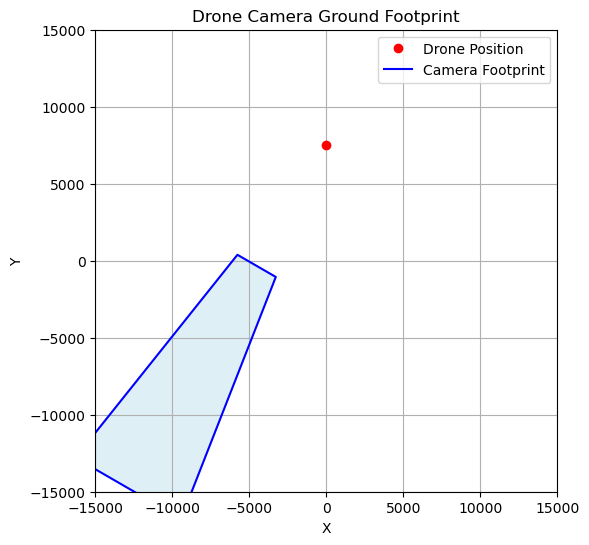

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def compute_vfov_from_hfov(hfov_deg, width, height):
    hfov_rad = np.radians(hfov_deg)
    aspect_ratio = height / width
    vfov_rad = 2 * np.arctan(np.tan(hfov_rad / 2) * aspect_ratio)
    return np.degrees(vfov_rad)

def get_ground_corners(x, y, h, theta_deg, phi_deg, hfov_deg, width=1280, height=720):
    vfov_deg = compute_vfov_from_hfov(hfov_deg, width, height)

    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)
    hfov = np.radians(hfov_deg)
    vfov = np.radians(vfov_deg)

    corners = np.array([
        [np.tan(hfov/2),  np.tan(vfov/2), -1],
        [-np.tan(hfov/2),  np.tan(vfov/2), -1],
        [-np.tan(hfov/2), -np.tan(vfov/2), -1],
        [np.tan(hfov/2), -np.tan(vfov/2), -1],
    ])

    dirs = corners / np.linalg.norm(corners, axis=1, keepdims=True)

    R_yaw = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])

    R_pitch = np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi),  np.cos(phi)]
    ])

    R = R_yaw @ R_pitch
    world_dirs = dirs @ R.T

    corners_world = []
    for d in world_dirs:
        scale = -h / d[2]
        point = np.array([x, y, h]) + scale * d
        corners_world.append(point[:2])
    return np.array(corners_world)

def compute_polygon_area(points):
    # Shoelace formula for area of polygon
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def plot_drone_view(corners, drone_pos, range_xy=15000):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(*drone_pos, 'ro', label='Drone Position')

    polygon = np.vstack([corners, corners[0]])
    ax.plot(polygon[:, 0], polygon[:, 1], 'b-', label='Camera Footprint')
    ax.fill(polygon[:, 0], polygon[:, 1], color='lightblue', alpha=0.4)

    # קביעת טווח הצירים לפי המרכז שאתה רוצה
    ax.set_xlim(- range_xy, range_xy)
    ax.set_ylim(- range_xy, range_xy)

    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Drone Camera Ground Footprint")
    plt.show()

# Example simulation
x, y = 0, 7500
h = 2500
theta = 150  # yaw
phi = 79.5    # pitch
hfov = 17.5   # horizontal field of view


corners = get_ground_corners(x, y, h, theta, phi, hfov)
print(corners)
area = compute_polygon_area(corners)
print("Drone position:", (x, y))
print("Projected footprint area (m²):", area)

plot_drone_view(corners, (x, y))


phi=0.0, theta=270.0
phi=8.5, theta=270.0
phi=8.5, theta=360.0
phi=8.5, theta=450.0
phi=8.5, theta=540.0
phi=16.0, theta=270.0
phi=16.0, theta=321.42857142857144
phi=16.0, theta=372.8571428571429
phi=16.0, theta=424.2857142857143
phi=16.0, theta=475.7142857142857


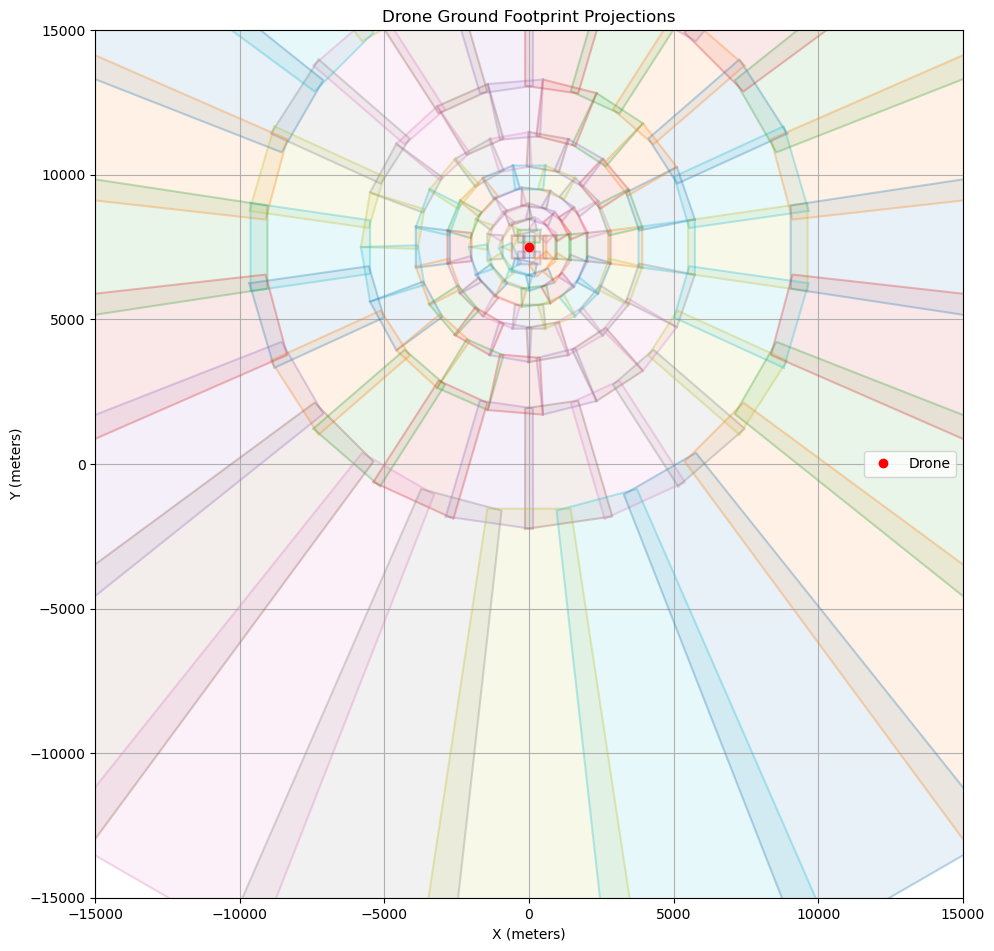

In [3]:
import numpy as np

# Define PHI and corresponding repetition counts
phi_values = [0, 8.5, 16, 25, 34, 43.5, 52.5, 61.5, 70.5, 79.5]
repetitions = [1, 4, 7, 10, 13, 16, 18, 19, 22, 24]

# Build PHI and THETA lists
PHI = []
THETA = []

for phi, reps in zip(phi_values, repetitions):
    PHI.extend([phi] * reps)
    step = 360 / reps
    theta_values = [270 + step * i for i in range(reps)]
    THETA.extend(theta_values)

# Convert to numpy arrays (optional)
PHI = np.array(PHI)
THETA = np.array(THETA)

# Example check
for p, t in zip(PHI[:10], THETA[:10]):
    print(f"phi={p}, theta={t}")



# Initialize plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.set_title("Drone Ground Footprint Projections")
ax.grid(True)

range_xy = 15000
ax.set_xlim(-range_xy, range_xy)
ax.set_ylim(-range_xy, range_xy)

# Loop over phi-theta pairs
for phi, theta in zip(PHI, THETA):
    corners = get_ground_corners(x, y, h, theta, phi, hfov)
    polygon = np.vstack([corners, corners[0]])  # Close polygon
    ax.plot(polygon[:, 0], polygon[:, 1], alpha=0.3)       # Outline
    ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.1)       # Fill

# Mark drone position
ax.plot(x, y, 'ro', label="Drone")

ax.legend()
plt.tight_layout()
plt.show()


## Find grid -> pixel

In [4]:
# Define world grid parameters
# lon_origin, lon_max = 30.0, 36.0
# lat_origin, lat_max = 34.0, 37.0
# resolution = 0.002
lon_origin, lon_max = -15000 , 15000
lat_origin, lat_max = -15000 , 15000
resolution = 0.25

grid_width = int((lon_max - lon_origin) / resolution)
grid_height = int((lat_max - lat_origin) / resolution)

# Grid → world
pts_grid = np.array([
    [0, 0],
    [grid_width - 1, 0],
    [grid_width - 1, grid_height - 1],
    [0, grid_height - 1]
], dtype=np.float32)

pts_world_grid = np.array([
    [lon_origin, lat_origin],
    [lon_origin + (grid_width - 1) * resolution, lat_origin],
    [lon_origin + (grid_width - 1) * resolution, lat_origin + (grid_height - 1) * resolution],
    [lon_origin, lat_origin + (grid_height - 1) * resolution]
], dtype=np.float32)

# World → image
image_width = 1280
image_height = 720

pts_image = np.array([
      [0, 0],  # top-left
      [image_width - 1, 0],  # top-right
      [image_width - 1, image_height - 1],  # bottom-right
      [0, image_height - 1]  # bottom-left
  ], dtype=np.float32)

pts_world_image = corners


H_grid_to_world = create_homography(pts_world_grid, pts_grid)
H_world_to_image = create_homography(pts_image, pts_world_image)



In [5]:
# image = np.fromfunction(lambda y, x: y + x, (image_height, image_width), dtype=np.uint8)
# image = image/100

image = create_synthetic_image_with_clusters(
    image_height=720,
    image_width=1280,
    background_range=(0, 0),
    cluster_value=255,
    num_clusters_range=(1,1),
    cluster_radius_range=(1, 3)
)


# Add uniform noisy spots
# add_uniform_spots(
#     image,
#     value_range=(50, 100),
#     spot_radius_range=(15, 30),
#     num_spots_range=(1, 4)
# )

# image = np.fromfunction(lambda y, x: y + x, (image_height, image_width), dtype=np.uint8)
# image = image/100


# Create original grid (example values)
# original_grid  = np.random.uniform(0, 0, size=(grid_height, grid_width)).astype(np.uint8)
original_grid  = np.zeros((grid_height, grid_width), dtype=np.uint8)


# # === Plotting ===
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# extent = [lon_origin, lon_max - resolution, lat_origin, lat_max - resolution]

# # First: world grid
# im0 = axs[0].imshow(original_grid, origin='lower', cmap='gray', extent=extent)
# axs[0].set_title("Original World Grid (LON/LAT)")
# axs[0].set_xlabel("Longitude (°)")
# axs[0].set_ylabel("Latitude (°)")

# # Second: captured image
# im1 = axs[1].imshow(image, cmap='gray')
# axs[1].set_title("Captured Image")
# axs[1].set_xlabel("Pixel X")
# axs[1].set_ylabel("Pixel Y")

# # Optional colorbar for the first plot (world grid)
# fig.colorbar(im0, ax=axs[0], shrink=0.8)

# plt.tight_layout()
# plt.show()


## Cropping a Grid Patch Based the Image Bounding Box

In [6]:
j_min, j_max, i_min, i_max = get_subgrid_bounds_precise(
    pts_world_image,
    lon_origin=lon_origin,
    lat_origin=lat_origin,
    resolution=resolution,
    grid_width=grid_width,
    grid_height=grid_height
)

print(f"X (j) range: {j_min} to {j_max}")
print(f"Y (i) range: {i_min} to {i_max}")

lon_min = lon_origin + j_min * resolution
lon_max = lon_origin + j_max * resolution
lat_min = lat_origin + i_min * resolution
lat_max = lat_origin + i_max * resolution

print (lon_min,lon_max, lat_min, lat_max)

# subgrid, i_start, i_end, j_start, j_end = extract_subgrid_from_bounds(
#     grid=original_grid,
#     j_min=j_min,
#     j_max=j_max,
#     i_min=i_min,
#     i_max=i_max
# )

from itertools import combinations
from math import sqrt

max_dist = 0
for a, b in combinations(corners, 2):
    dist = np.linalg.norm(a - b)
    if dist > max_dist:
        max_dist = dist

# שלב 4: הגדרת הרזולוציה
res = max_dist / (1280 * 2 * sqrt(2))
print(f"coarse res: {res}")

# subgrid = create_subgrid_from_bounds(
#     lon_min=lon_min,
#     lon_max=lon_max,
#     lat_min=lat_min,
#     lat_max=lat_max,
#     resolution = res
# )
subgrid, lon_vals, lat_vals = extract_and_resample_subgrid_interp(
    grid=original_grid,
    resolution=resolution,
    res=res,
    j_min=j_min, j_max=j_max,
    i_min=i_min, i_max=i_max
)


print(f"Subgrid shape: {subgrid.shape}")

extent = [
    lon_min,
    lon_max,
    lat_min,
    lat_max
]


print(extent)

X (j) range: 93452.0 to 119999
Y (i) range: 48053.0 to 86206.0
8363.0 14999.75 -2986.75 6551.5
coarse res: 4.8409857614957765
Subgrid shape: (1971, 1371)
[8363.0, 14999.75, -2986.75, 6551.5]


In [7]:
extent2 = [
    j_min,
    j_max,
    i_min,
    i_max
]
print(extent2)
print(type(subgrid))
print(subgrid.dtype)
subgrid

[93452.0, 119999, 48053.0, 86206.0]
<class 'numpy.ndarray'>
float64


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
# Grid → world
subgrid_width = subgrid.shape[1]
subgrid_height = subgrid.shape[0]

pts_subgrid = np.array([
    [0, 0],
    [subgrid_width - 1, 0],
    [subgrid_width - 1, subgrid_height - 1],
    [0, subgrid_height - 1]
], dtype=np.float32)

pts_world_subgrid = np.array([
    [lon_min, lat_min],
    [lon_min + (subgrid_width - 1) * res, lat_min],
    [lon_min + (subgrid_width - 1) * res, lat_min + (subgrid_height - 1) * res],
    [lon_min, lat_min + (subgrid_height - 1) * res]
], dtype=np.float32)

H_subgrid_to_world = create_homography(pts_world_subgrid, pts_subgrid)

# Warp the image onto the subgrid
projected_image_on_subgrid = warp_image_to_grid(subgrid, image, H_subgrid_to_world, H_world_to_image, subgrid_height, subgrid_width)

# הגענו לפה,, צריך לעשות השוואה בין הרשת המוטלת לגסה שנוציא מהמקורית, לא בדקנו את הפונקציה שיוצרת את הרשת הגסה, צריך לדאוג שהרשת המוטלת והגסה החתוכה יווצרו עם אותן משתנים


# 2. Preprocess
subgrid, projected_image_on_subgrid = preprocess_images(subgrid, projected_image_on_subgrid, applying=1)

# 3. Compute difference (only positive changes)
diff_map_subgrid = compute_positive_difference(subgrid, projected_image_on_subgrid)

# 4. Filter mask
diff_map_subgrid = postprocess_difference_map(diff_map_subgrid, projected_image_on_subgrid, threshold=0, temp_threshold=0)


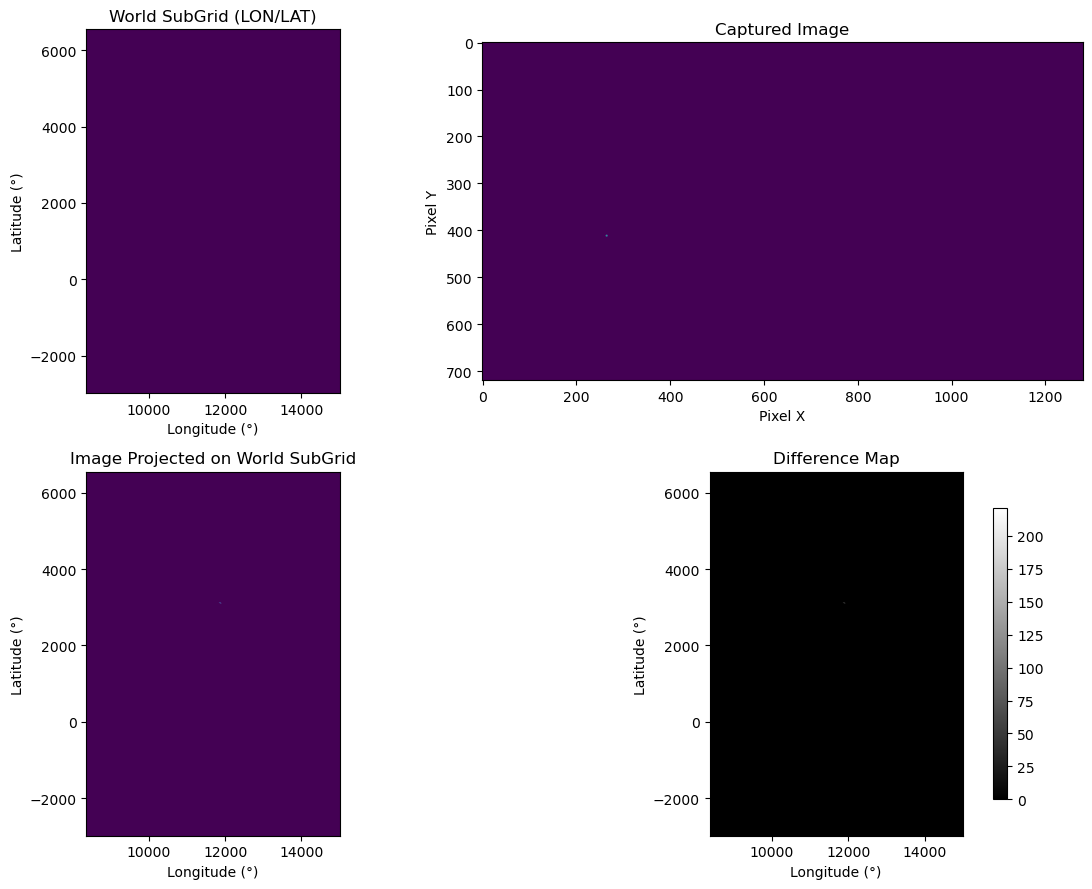

In [9]:

# === Plotting ===
fig, axs = plt.subplots(2, 2, figsize=(12, 9))

axs[0, 0].imshow(subgrid, origin='lower', cmap='viridis', extent=extent)
axs[0, 0].set_title("World SubGrid (LON/LAT)")
axs[0, 0].set_xlabel("Longitude (°)")
axs[0, 0].set_ylabel("Latitude (°)")

axs[0, 1].imshow(image, cmap='viridis')
axs[0, 1].set_title("Captured Image")
axs[0, 1].set_xlabel("Pixel X")
axs[0, 1].set_ylabel("Pixel Y")

# Image projected on world grid (in lon/lat coordinates)
axs[1, 0].imshow(projected_image_on_subgrid, origin='lower', cmap='viridis', extent=extent)
axs[1, 0].set_title("Image Projected on World SubGrid")
axs[1, 0].set_xlabel("Longitude (°)")
axs[1, 0].set_ylabel("Latitude (°)")


# Difference map in lon/lat
im = axs[1, 1].imshow(diff_map_subgrid, origin='lower', cmap='gray', vmin=0, vmax=np.max(diff_map_subgrid), extent=extent)
axs[1, 1].set_title("Difference Map")
axs[1, 1].set_xlabel("Longitude (°)")
axs[1, 1].set_ylabel("Latitude (°)")


fig.colorbar(im, ax=axs[1, 1], shrink=0.8)

plt.tight_layout()
plt.show()


# plt.figure(figsize=(8, 4))
# plt.hist(diff_map_subgrid[diff_map_subgrid > 10].ravel(), bins=100, color='gray')
# plt.title("Histogram of Difference Map Values")
# plt.xlabel("Difference Value")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [12]:
diff_map_subgrid.max()

220.99877916144416

1
Detected centers:
Center at (y=1261.7, x=724.5)


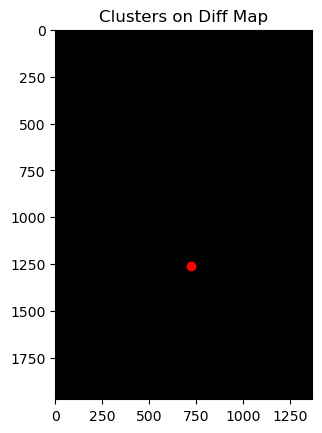

In [10]:
import numpy as np
from sklearn.cluster import DBSCAN

def get_cluster_centers_from_diff(diff_map, threshold=10, eps=1.5, min_samples=1):
    """
    Applies DBSCAN clustering on high-difference pixels in a diff map and returns cluster centers.

    Parameters:
        diff_map: 2D array of differences
        threshold: minimum value to consider a pixel as "active"
        eps: DBSCAN eps parameter (radius for neighborhood)
        min_samples: DBSCAN min_samples parameter (min points per cluster)

    Returns:
        centers: list of (y, x) tuples representing the center of each cluster
        labels: 2D array of same shape as diff_map, showing cluster index per pixel (-1 = noise)
    """
    # Step 1: extract pixel coordinates above threshold
    hot_pixels = np.argwhere(diff_map > threshold)  # shape: (N, 2), (y, x)

    if len(hot_pixels) == 0:
        return [], np.full_like(diff_map, -1, dtype=int)  # no clusters

    # Step 2: apply DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(hot_pixels)
    labels_flat = clustering.labels_  # length N

    # Step 3: build label map (same shape as diff_map)
    label_map = np.full(diff_map.shape, -1, dtype=int)
    for idx, (y, x) in enumerate(hot_pixels):
        label_map[y, x] = labels_flat[idx]

    # Step 4: compute cluster centers (mean of (y, x) in each label)
    centers = []
    for label_id in np.unique(labels_flat):
        if label_id == -1:
            continue  # skip noise
        points = hot_pixels[labels_flat == label_id]
        center = points.mean(axis=0)  # (y, x)
        centers.append(tuple(center))

    return centers, label_map


centers, label_map = get_cluster_centers_from_diff(
    diff_map=diff_map_subgrid,
    threshold=1,
    eps=1,
    min_samples=1
)

print(len(centers))
print("Detected centers:")
for c in centers:
    print(f"Center at (y={c[0]:.1f}, x={c[1]:.1f})")


import matplotlib.pyplot as plt

plt.imshow(diff_map_subgrid, cmap='gray')
for y, x in centers:
    plt.plot(x, y, 'ro')
plt.title("Clusters on Diff Map")
plt.show()


1
Detected centers:
Center at (y=1262.0, x=724.0)


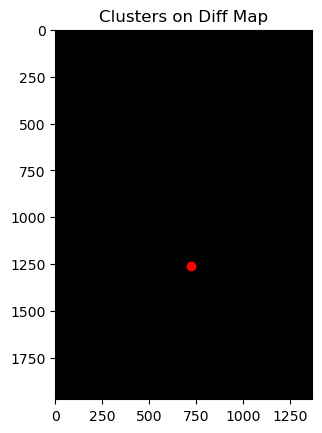

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

def find_cluster_centers_conditional(diff_map, threshold=10, eps=1.5, min_samples=2, min_contrast=10):
    """
    Applies DBSCAN on a diff map and returns the center of each cluster.
    If the contrast in the cluster (max - min) >= min_contrast, the center is the hottest point.
    Otherwise, the center is the geometric mean.

    Parameters:
        diff_map: 2D array
        threshold: only consider diff values above this
        eps: DBSCAN neighborhood radius
        min_samples: DBSCAN min points per cluster
        min_contrast: min difference (max - min) in a cluster to use the hottest point

    Returns:
        centers: list of (i, j) tuples
        label_map: same-shape array with cluster labels
    """
    active_pixels = np.argwhere(diff_map > threshold)
    if len(active_pixels) == 0:
        return [], np.full_like(diff_map, -1)

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(active_pixels)
    labels_flat = clustering.labels_

    label_map = np.full(diff_map.shape, -1, dtype=int)
    for idx, (i, j) in enumerate(active_pixels):
        label_map[i, j] = labels_flat[idx]

    centers = []
    for label in np.unique(labels_flat):
        if label == -1:
            continue  # skip noise

        cluster_points = active_pixels[labels_flat == label]
        values = diff_map[cluster_points[:, 0], cluster_points[:, 1]]
        contrast = values.max() - 2*values.mean()

        if contrast >= 0:
            # Use hottest point
            hottest_idx = np.argmax(values)
            center = cluster_points[hottest_idx]
        else:
            # Use geometric center
            center = cluster_points.mean(axis=0)

        centers.append(tuple(center))

    return centers, label_map


centers, label_map = find_cluster_centers_conditional(
    diff_map=diff_map_subgrid,
    threshold=1,
    eps=2,
    min_samples=2,
    min_contrast=1
)

print(len(centers))
print("Detected centers:")
for c in centers:
    print(f"Center at (y={c[0]:.1f}, x={c[1]:.1f})")


import matplotlib.pyplot as plt

plt.imshow(diff_map_subgrid, cmap='gray')
for y, x in centers:
    plt.plot(x, y, 'ro')
plt.title("Clusters on Diff Map")
plt.show()

## הדפסת החתיכה מהרשת

In [12]:
def plot_grid_with_subgrid_box(grid, j_min, j_max, i_min, i_max,
                                lon_origin, lat_origin, resolution):
    """
    Plots the full grid with LON/LAT axes and overlays a red rectangle
    showing the subgrid bounds.
    """
    # 1. המרת גבולות תת הרשת ל־lon/lat
    lon_min = lon_origin + j_min * resolution
    lon_max = lon_origin + j_max * resolution
    lat_min = lat_origin + i_min * resolution
    lat_max = lat_origin + i_max * resolution

    # 2. טווח המפה המלאה
    grid_height, grid_width = grid.shape
    extent_full = [
        lon_origin,
        lon_origin + grid_width * resolution,
        lat_origin,
        lat_origin + grid_height * resolution
    ]

    # 3. הדפסה
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.imshow(grid, origin='lower', cmap='viridis', extent=extent_full)
    ax.set_title("World Grid with Subgrid Overlay")
    ax.set_xlabel("Longitude (°)")
    ax.set_ylabel("Latitude (°)")

    # 4. מלבן מסומן
    rect = plt.Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        linestyle='--'
    )
    ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

j_min, j_max, i_min, i_max = get_subgrid_bounds_precise(
    pts_world_image,
    lon_origin=30.0,
    lat_origin=34.0,
    resolution=0.02
)

plot_grid_with_subgrid_box(
    grid=projected_image_on_grid,
    j_min=j_min,
    j_max=j_max,
    i_min=i_min,
    i_max=i_max,
    lon_origin=30.0,
    lat_origin=34.0,
    resolution=0.02
)



NameError: name 'projected_image_on_grid' is not defined